# Exploratory Data Analysis

## Lyrics Analysis

In [12]:
import json

# Read lyrics_corpus
with open('data/lyrics_corpus.json', 'r') as lyrics_file:
    all_lyrics = json.load(lyrics_file)

In [14]:
import nltk
import matplotlib.pyplot as plt

all_lyrics_raw = ' '.join(all_lyrics.values())


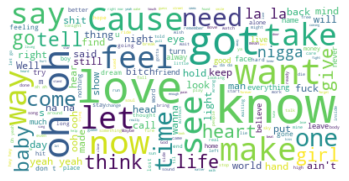

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=60, background_color = 'white').generate(all_lyrics_raw)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()